In [224]:
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.io import loadmat

在推荐系统作业中，我们使用协同过滤算法应用于一个电影评分数据集中。


## 读入数据
首先读入数据。movies_mat中包含了Y和R两组数据，其中Y为用户给电影平的分（0-5），R为用户是否给电影评分,两者维度相同。params_mat包含一组预训练的参数电影特征X和用户参数Theta。

In [225]:
movies_mat = sio.loadmat('./data/ex8_movies.mat')
Y,R = movies_mat['Y'],movies_mat['R']
print(Y.shape,R.shape)

params_mat = sio.loadmat('./data/ex8_movieParams.mat')
X,Theta=params_mat['X'],params_mat['Theta']
print(X.shape,Theta.shape)

(1682, 943) (1682, 943)
(1682, 10) (943, 10)


## 定义代价函数及梯度算法
接下来，定义协同过滤算法的代价函数及梯度，并进行测试。

In [226]:
def cost(Y,R,Theta,X,n_feature,lam):
    
    error = np.dot(X,Theta.T)-Y
    j = 0.5 * np.sum((error**2)*R) + 0.5*lam*np.sum(X**2) + 0.5*lam*np.sum(Theta**2)
    Theta_grad = np.dot((error*R).T,X)+lam*Theta
    X_grad = np.dot((error*R),Theta)+lam*X
    
    return j,Theta_grad,X_grad

# 仅取部分数据进行测设
users = 4
movies = 5
features = 3

X_sub = X[:movies, :features]
Theta_sub = Theta[:users, :features]
Y_sub = Y[:movies, :users]
R_sub = R[:movies, :users]

j,Theta_grad,X_grad = cost(Y_sub,R_sub,Theta_sub,X_sub,features,1.5)
print(j)
print(Theta_grad)
print(X_grad)

31.344056244274217
[[-10.13985478   2.10136256  -6.76563628]
 [ -2.29347024   0.48244098  -2.99791422]
 [ -0.64787484  -0.71820673   1.27006666]
 [  1.09289758  -0.40784086   0.49026541]]
[[-0.95596339  6.97535514 -0.10861109]
 [ 0.60308088  2.77421145  0.25839822]
 [ 0.12985616  4.0898522  -0.89247334]
 [ 0.29684395  1.06300933  0.66738144]
 [ 0.60252677  4.90185327 -0.19747928]]


## 读入电影名称
上述计算结果与预期相同，下面我们打开movie_ids.txt文件，这个文件提供了1682部电影的名称，我们可以读入文件，并创建一个电影序号到其名称的字典。

In [227]:
movies_idx={}
with open('./data/movie_ids.txt') as f:
    for line in f:
        tokens = line.split(' ')
        key = tokens[0]
        value = ' '.join(tokens[1:])
        movies_idx[int(key)-1]=value

## 加入个人评分并更新数据
下面使用练习中提供的评分作为自己的评分,并把这个评分加入到评分矩阵Y和R中。

In [228]:
ratings = np.zeros(1682)

ratings[0] = 4
ratings[6] = 3
ratings[11] = 5
ratings[53] = 4
ratings[63] = 5
ratings[65] = 3
ratings[68] = 5
ratings[97] = 2
ratings[182] = 4
ratings[225] = 5
ratings[354] = 5

for i in range(1682):
    if int(ratings[i]) != 0:
        print('rated {0} for {1}'.format(str(int(ratings[i])), movies_idx[i]))
        
Y,R = movies_mat['Y'],movies_mat['R']
Y = np.insert(Y, 0, ratings, axis=1)
R = np.insert(R, 0, ratings!=0, axis = 1)
print(Y.shape,R.shape)

rated 4 for Toy Story (1995)

rated 3 for Twelve Monkeys (1995)

rated 5 for Usual Suspects, The (1995)

rated 4 for Outbreak (1995)

rated 5 for Shawshank Redemption, The (1994)

rated 3 for While You Were Sleeping (1995)

rated 5 for Forrest Gump (1994)

rated 2 for Silence of the Lambs, The (1991)

rated 4 for Alien (1979)

rated 5 for Die Hard 2 (1990)

rated 5 for Sphere (1998)

(1682, 944) (1682, 944)


## 初始化参数
对电影特征及用户参数进行初始化,并对评分矩阵Y进行归一化

In [268]:
movies = Y.shape[0]
users = Y.shape[1]
features = 50
lam = 1
learning_rate= 0.003
iters  =  1000000
Theta = np.random.randn(users,features)
X = np.random.randn(movies,features)

Y_mean = (np.sum(Y, axis=1)/np.sum(R,axis=1)).reshape(1682,1)
Y_norm = (Y - Y_mean)*R
np.mean(Y_norm)

7.338986115742988e-19

## 训练

cost after 0 iter: 8283.384866325963
cost after 50 iter: 8282.903717410212
cost after 100 iter: 8282.425024485085
cost after 1000000 iter: 8282.41547568679


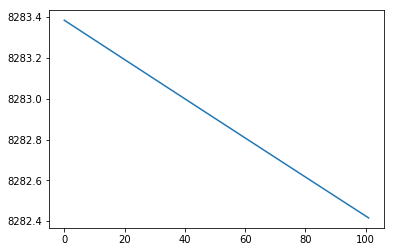

In [278]:
j_list = []
for i in range(iters):
    j,Theta_grad,X_grad = cost(Y_norm,R,Theta,X,features,lam)
    X = X - learning_rate*X_grad
    Theta = Theta - learning_rate*Theta_grad
    j_list.append(j)
    if i %50 == 0:
        print('cost after '+str(i)+' iter:',j)
    if i > 100 :
        if j_list[i-200] - j_list[i] < 1:
            break
print('cost after '+str(iters)+' iter:',j)
plt.plot(j_list)
plt.show()

## 预测
进行预测并打印出预测评分前10的电影。

In [275]:
prediction = X @ Theta.T
my_preds = prediction[:, 0] + np.squeeze(Y_mean)
my_preds.shape

(1682,)

In [276]:
idx = np.argsort(my_preds, axis=0)[::-1]
idx

array([  95,  186,   49, ...,  829, 1573,  423], dtype=int64)

In [277]:
print("Top 10 movie predictions:")
for i in range(10):
    j = int(idx[i])
    print('Predicted rating of {0} for movie {1}'.format(str(float(my_preds[j])), movies_idx[j]))

Top 10 movie predictions:
Predicted rating of 5.491322023246072 for movie Terminator 2: Judgment Day (1991)

Predicted rating of 5.445519167953797 for movie Godfather: Part II, The (1974)

Predicted rating of 5.345872473529196 for movie Star Wars (1977)

Predicted rating of 5.334388794335587 for movie Tomorrow Never Dies (1997)

Predicted rating of 5.171844281754199 for movie Princess Bride, The (1987)

Predicted rating of 5.109164633438269 for movie Godfather, The (1972)

Predicted rating of 5.071775247027251 for movie Monty Python and the Holy Grail (1974)

Predicted rating of 5.053473763368055 for movie Terminator, The (1984)

Predicted rating of 5.0 for movie Saint of Fort Washington, The (1993)

Predicted rating of 5.0 for movie Entertaining Angels: The Dorothy Day Story (1996)



----
# 使用scipy.optimize.minimize
scipy提供了scipy.optimize.minimize来自动求解最优解，首先我们先读入并生成数据

In [233]:
from scipy.optimize import minimize

movies_mat = sio.loadmat('./data/ex8_movies.mat')
Y,R = movies_mat['Y'],movies_mat['R']
Y = np.insert(Y, 0, ratings, axis=1)
R = np.insert(R, 0, ratings!=0, axis = 1)

movies = Y.shape[0]
users = Y.shape[1]
features = 50
lam = 1
learning_rate= 0.001
iters  =  500
Theta = np.random.randn(users,features)
X = np.random.randn(movies,features)

Y_mean = (np.sum(Y, axis=1)/np.sum(R,axis=1)).reshape(1682,1)
Y_norm = (Y - Y_mean)*R

params = np.concatenate((X.ravel(), Theta.ravel()))

构建cost和grad，这里的params包含了X和theta两个参数

In [234]:
def cost2(params, Y, R, features,lam):
    X = params[:movies*features].reshape(movies,features)
    Theta = params[movies*features:].reshape(users,features)
    
    error = np.dot(X,Theta.T)-Y
    j = 0.5 * np.sum((error**2)*R) + 0.5*lam*np.sum(X**2) + 0.5*lam*np.sum(Theta**2)

    return j

def grad(params, Y, R, features,lam):
    X = params[:movies*features].reshape(movies,features)
    Theta = params[movies*features:].reshape(users,features)
    error = np.dot(X,Theta.T)-Y
    Theta_grad = np.dot((error*R).T,X)+lam*Theta
    X_grad = np.dot((error*R),Theta)+lam*X
    return np.concatenate((X_grad.ravel(), Theta_grad.ravel()))

In [249]:
fmin = minimize(fun=cost2,
                   x0=params,
                   args=(Y_norm, R, features, lam),
                   method='TNC',
                   jac=grad,
                   options={'maxiter': 500})
fmin

     fun: 8334.05022220338
     jac: array([-0.28603871, -0.03257379, -0.20231759, ..., -0.00049754,
        0.00149946,  0.00034379])
 message: 'Max. number of function evaluations reached'
    nfev: 500
     nit: 34
  status: 3
 success: False
       x: array([-0.02350563, -0.21776081,  0.2114523 , ...,  0.28980342,
        0.22598878, -0.3156141 ])

In [250]:
X = np.reshape(fmin.x[:movies * features], (movies, features))
Theta = np.reshape(fmin.x[movies * features:], (users, features))
prediction = X @ Theta.T
my_preds = prediction[:, 0] + np.squeeze(Y_mean)
idx = np.argsort(my_preds, axis=0)[::-1]
print(idx)
for i in range(10):
    j = int(idx[i])
    print('Predicted rating of {0} for movie {1}'.format(str(float(my_preds[j])), movies_idx[j]))

[ 126   49  245 ...  438 1333  857]
Predicted rating of 5.442228203746181 for movie Godfather, The (1972)

Predicted rating of 5.428331296385471 for movie Star Wars (1977)

Predicted rating of 5.327453348681676 for movie Chasing Amy (1997)

Predicted rating of 5.2945139078605665 for movie Empire Strikes Back, The (1980)

Predicted rating of 5.280404949321147 for movie Bridge on the River Kwai, The (1957)

Predicted rating of 5.211371099022442 for movie Secrets & Lies (1996)

Predicted rating of 5.210082813355116 for movie Terminator 2: Judgment Day (1991)

Predicted rating of 5.197186632008606 for movie Duck Soup (1933)

Predicted rating of 5.183475058247489 for movie Terminator, The (1984)

Predicted rating of 5.1762519803701075 for movie Titanic (1997)

